# Plots for the Clustering Paper

This notebook contains all the plots made for the clustering paper.

In [48]:
from astropy.cosmology import Planck15
from astropy import units as un
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.colors import LogNorm
%matplotlib inline

import numpy as np

from scipy.interpolate import InterpolatedUnivariateSpline as spline, griddata

from powerbox.tools import angular_average, get_power
from powerbox.dft import fft
from powerbox.powerbox import _magnitude_grid

%load_ext fortranmagic

from os.path import join

The fortranmagic extension is already loaded. To reload it, use:
  %reload_ext fortranmagic


This notebook produced with ``spore`` version:

## Connect To Instruments

### Get Power Spectrum from Basic Box

In [6]:
pk_2d, kperp, kpar, simdat = pssim.get_power_lightcone("/home/steven/Documents/Projects/Foregrounds/DataSets/delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel", 
                                               get_delta=False, res_ndim=2, taper=blackmanharris)

pk_1d, kav_1d = pssim.get_power_lightcone("/home/steven/Documents/Projects/Foregrounds/DataSets/delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel", taper=blackmanharris)

simf0 = np.linspace(1,simdat['nu'].max()/simdat['nu'].min(),len(simdat['nu']))
sim_u = Planck15.h*Planck15.comoving_distance(simdat['z'].min()) * kperp/(2*np.pi)

{'dim': 1024, 'BoxSize': 1600, 'basedir': '/home/steven/Documents/Projects/Foregrounds/DataSets', 'HIIdim': 1024, 'filename': 'delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel', 'z': 0.0, 'type': 'deltaT'}
[ 5.          5.00446531  5.00893062 ...,  9.55907938  9.56354469  9.56801   ] [ 7955.26716772  7957.67083891  7960.07185629 ...,  9550.11164822
  9551.14519859  9552.17809448] Mpc
{'dim': 1024, 'BoxSize': 1600, 'basedir': '/home/steven/Documents/Projects/Foregrounds/DataSets', 'HIIdim': 1024, 'filename': 'delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel', 'z': 0.0, 'type': 'deltaT'}
[ 5.          5.00446531  5.00893062 ...,  9.55907938  9.56354469  9.56801   ] [ 7955.26716772  7957.67083891  7960.07185629 ...,  9550.11164822
  9551.14519859  9552.17809448] Mpc


KeyboardInterrupt: 

Plot the 2D power spectrum of the raw EoR simulation, to get a feel for where the power really is:

In [7]:
from spore.mock.convert_sim_to_vis import get_cut_box

In [8]:
box, N, L, d, nu, z = get_cut_box("../../DataSets/delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel",
                                  numin=150.0, numax=153.)

{'dim': 1024, 'BoxSize': 1600, 'basedir': '../../DataSets', 'HIIdim': 1024, 'filename': 'delta_T_v3_no_halos__zstart005.00000_zend009.56801_FLIPBOXES0_1024_1600Mpc_lighttravel', 'z': 0.0, 'type': 'deltaT'}
[ 5.          5.00446531  5.00893062 ...,  9.55907938  9.56354469  9.56801   ] [ 7955.26716772  7957.67083891  7960.07185629 ...,  9550.11164822
  9551.14519859  9552.17809448] Mpc


In [15]:
box0 = box[:,:,0]

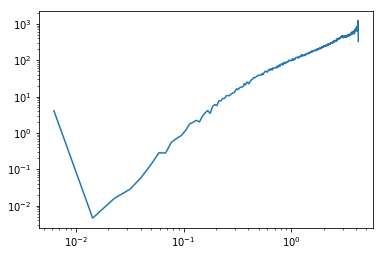

In [22]:
power_2d, k2d = get_power(box0, boxlength=L)
plt.plot(k2d, power_2d * k2d**3)
plt.xscale('log')
plt.yscale('log')

In [17]:
import numpy as np

In [19]:
bigbox = np.hstack((box0, box0))
bigbox = np.vstack((bigbox, bigbox))

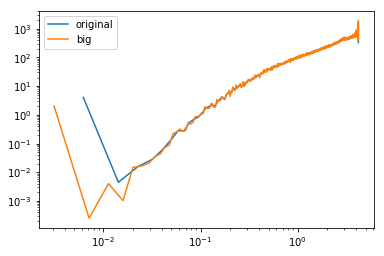

In [24]:
power_2d, k2d = get_power(box0, boxlength=L)
power_2dbig, k2dbig = get_power(bigbox, boxlength=L*2)
plt.plot(k2d, power_2d * k2d**3, label='original')
plt.plot(k2dbig, power_2dbig * k2dbig**3, label="big")

plt.legend()
plt.xscale('log')
plt.yscale('log')

In [30]:
%%fortran

subroutine coarsen(nx_in,ny_in, nx_out, ny_out, a, coarsened)
        implicit none
        integer, intent(in) :: nx_in, ny_in, nx_out, ny_out
        real(8), intent(in) :: a(nx_in,ny_in) ! input matrix
        real(8), intent(out) :: coarsened(nx_out, ny_out)

        integer :: ix,iy, ix_out, iy_out
        real :: size_ratio_x, size_ratio_y, this_edge_x, ne_x, this_edge_y, ne_y

        size_ratio_x = real(nx_in)/real(nx_out)     
        size_ratio_y = real(ny_in)/real(ny_out)     
                
        this_edge_x = 0.0
        ne_x = size_ratio_x
        ix_out = 1

        coarsened(:,:) = 0.d0
        do ix=0,nx_in-1
            
            this_edge_y = 0.0
            ne_y = size_ratio_y
            iy_out = 1

            if (ix>ne_x) then
                this_edge_x = this_edge_x + size_ratio_x
                ne_x = ne_x + size_ratio_x                    
                ix_out = ix_out + 1
            endif

                
            do iy=0,ny_in-1
                

                if (iy>ne_y) then
                    this_edge_y = this_edge_y + size_ratio_y
                    ne_y = ne_y + size_ratio_y
                    iy_out = iy_out + 1
                endif
    
                write(*,*) ix, iy, size_ratio_x, this_edge_x, this_edge_y, ne_x, ne_y, ix_out, iy_out
        
                coarsened(ix_out, iy_out) = coarsened(ix_out, iy_out) + (ne_x - ix)*(ne_y - iy) * a(ix+1,iy+1)                        
                if (ix+1 - ne_x > 0.0) then
                    coarsened(ix_out+1, iy_out) = coarsened(ix_out+1, iy_out) + (ix+1 - ne_x)*(ne_y - iy) * a(ix+1,iy+1)
                end if
                if (iy+1 - ne_y > 0.0) then
                    coarsened(ix_out, iy_out+1) = coarsened(ix_out, iy_out+1) + (ne_x-ix)*(iy+1 - ne_y) * a(ix+1,iy+1)
                end if

                if (ix+1 - ne_x > 0.0 .and. iy+1 - ne_y > 0.0 ) then
                    coarsened(ix_out+1, iy_out+1) = coarsened(ix_out+1, iy_out+1) + (ix+1 - ne_x)*(iy+1 - ne_y) * a(ix+1,iy+1)
                end if
                
                                
            end do        
        end do
        
        coarsened = coarsened / (size_ratio_x*size_ratio_y)
    end subroutine

In [32]:
coarse_box= coarsen(1024, 1024, bigbox)

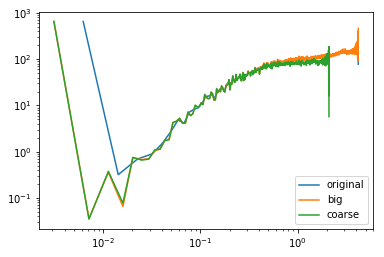

In [34]:
power_2d, k2d = get_power(box0, boxlength=L)
power_2dbig, k2dbig = get_power(bigbox, boxlength=L*2)
power_2dcoarse, k2dcoarse = get_power(coarse_box, boxlength=L*2)


plt.plot(k2d, power_2d * k2d**2, label='original')
plt.plot(k2dbig, power_2dbig * k2dbig**2, label="big")
plt.plot(k2dcoarse, power_2dcoarse * k2dcoarse**2, label="coarse")

plt.legend()
plt.xscale('log')
plt.yscale('log')

## 3D

In [35]:
bigbox3d = np.concatenate?

In [36]:
bigbox3d = np.concatenate((box,box))
bigbox3d = np.concatenate((bigbox3d, bigbox3d), axis=1)

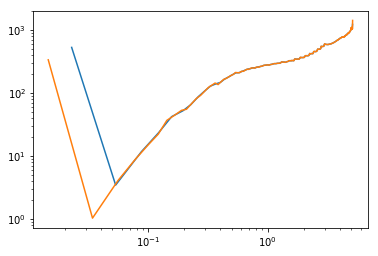

In [41]:
power_3d, k3d = get_power(box, boxlength=[L,L,d[-1]-d[0]])
power_3dbig, k3dbig = get_power(bigbox3d, boxlength=[L*2, L*2, d[-1]-d[0]])

plt.plot(k3d, power_3d * k3d**3, label='original')
plt.plot(k3dbig, power_3dbig * k3dbig**3, label="big")
plt.xscale('log')
plt.yscale("log")

In [46]:
coarse_3d = np.zeros_like(box)

for i in range(box.shape[-1]):
    coarse_3d[:,:,i] = coarsen(box.shape[0], box.shape[1], bigbox3d[:,:,i])
    
power_3dcoarse, k3dcoarse = get_power(coarse_3d, boxlength=[L*2,L*2,d[-1]-d[0]])

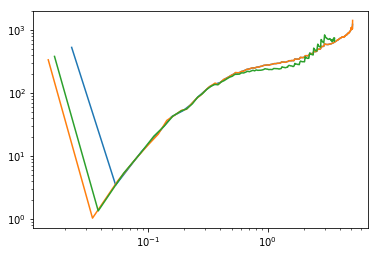

In [47]:
plt.plot(k3d, power_3d * k3d**3, label='original')
plt.plot(k3dbig, power_3dbig * k3dbig**3, label="big")
plt.plot(k3dcoarse, power_3dcoarse * k3dcoarse**3, label="coarse")

plt.xscale('log')
plt.yscale("log")

In [ ]:

power_2d, k2d = get_power(box0, boxlength=L)

bigbox = np.hstack((box0, box0))
bigbox = np.vstack((bigbox, bigbox))
power_2dbig, k2dbig = get_power(bigbox, boxlength=L*2)


power_2dcoarse, k2dcoarse = get_power(coarse_box, boxlength=L*2)


plt.plot(k2d, power_2d * k2d**2, label='original')
plt.plot(k2dbig, power_2dbig * k2dbig**2, label="big")
plt.plot(k2dcoarse, power_2dcoarse * k2dcoarse**2, label="coarse")

plt.legend()
plt.xscale('log')
plt.yscale('log')